# Computational Bionics: Project Exercise 1

Group members:
- Yash Waware (12329556)
- Julian Lork (12243805)
- Florian Frech (12308544)

------------------------

## Task 1: Basic System Model
### 1.1 Description

The following section considers the combination of the sub models of the leg and the hip drive.

A PID controller which controls the hip angle according to the provided gait data.
The model only considers the swing phase. The simulation is started at toe off and stops when the leg has ground contact again. In the swing phase there are no acting ground reaction forces and foot moments.

An ideal digital controller (no quantization) with a sampling time of $dt = 0.1$ seconds is used.
$$f = \frac{1}{dt} = 10 Hz$$

Further, an ideal analog sensor for the hip and knee angle is used. The hip and knee angles $q_1$ and $q_2$ are directly used without quantization.

A simple ideal damper in the knee is used to stabilize the system:
$$M_2 = D \cdot \omega_2$$

**PID Controller**

We consider the classic PID (Proprtional-Integrating-Differential) controller

$$u(t) = K_p e(t) + K_I \int e(t) dt + K_D \frac{de(t)}{dt}$$

$$G_R(s) = K_P + \frac{K_I}{s} + K_D s = \frac{K_D s^2 + K_P s + K_I}{s}$$

 - $K_P$: controller gain
 - $K_I$: integrator gain
 - $K_D$: differentiator gain

#### 1.2 Simplified Box Model

### 1.3 Implementation

#### 1.3.1 Leg Model

In [173]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [174]:
# Define the symbolic variables
q1, q2, omega1, omega2 = sp.symbols(r'q_1 q_2 \omega_1 \omega_2')
dot_omega1, dot_omega2 = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
l1, l2, L1, L2 = sp.symbols(r'l_1 l_2 L_1 L_2')
m1, m2, m3 = sp.symbols(r'm_1 m_2 m_3')
J1, J2 = sp.symbols(r'J_1 J_2')
T1_sym, T2_sym = sp.symbols(r'T_1 T_2')
b1, b2 = sp.symbols(r'b_1 b_2')
t, g = sp.symbols('t g')

q1 = sp.Function('q_1')(t)
q2 = sp.Function('q_2')(t)

w1 = q1.diff(t)
w2 = q2.diff(t)

dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

**Euler-Lagrange Formulation**

In [175]:
# Position of the center of mass for tigh, shank and foot
r1 = Matrix([l1 * sin(q1),
             -l1 * cos(q1)])

r2 = Matrix([L1 * sin(q1) + l2 * sin(q2),
             -L1 * cos(q1) - l2 * cos(q2)])

r3 = Matrix([L1 * sin(q1) + L2 * sin(q2),
            -L1 * cos(q1) - L2 * cos(q2)])

# Velocity of the center of mass for tigh, shank and foot
v1 = r1.diff(t)
v2 = r2.diff(t)
v3 = r3.diff(t)

# Kinetic energy of the system
T1 = 0.5 * m1 * v1.dot(v1) + 0.5 * J1 * q1.diff(t)**2
T2 = 0.5 * m2 * v2.dot(v2) + 0.5 * J2 * q2.diff(t)**2
T3 = 0.5 * m3 * v3.dot(v3)
T_total = T1 + T2 + T3

# Potential energy of the system
h1 = -l1 * cos(q1)
h2 = -L1 * cos(q1) - l2 * cos(q2)
h3 = -L1 * cos(q1) - L2 * cos(q2)
V1 = m1 * g * h1
V2 = m2 * g * h2
V3 = m3 * g * h3
V_total = V1 + V2 + V3

L = T_total - V_total

**Setting up the system of Equations**

In [176]:
dL_d_dot_q1 = L.diff(q1.diff(t))
dL_d_dot_q2 = L.diff(q2.diff(t))

dL_d_dot_q1_dt = dL_d_dot_q1.diff(t)
dL_d_dot_q2_dt = dL_d_dot_q2.diff(t)

dL_dq1 = L.diff(q1)
dL_dq2 = L.diff(q2)

# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): dot_omega1,
            q2.diff(t, 2): dot_omega2,}

dL_d_dot_q1_dt.subs(subsDict).simplify()
dL_d_dot_q2_dt.subs(subsDict).simplify()

dL_dq1.subs(subsDict).simplify()
dL_dq2.subs(subsDict).simplify()

Q1 = T1_sym - b1 * q1.diff(t) - b2 * (q1.diff(t) - q2.diff(t))
Q2 = - b2 * (q2.diff(t) - q1.diff(t))

Q1.subs(subsDict).simplify()
Q2.subs(subsDict).simplify();

In [177]:
eq1 = dL_d_dot_q1_dt - dL_dq1 - Q1
eq2 = dL_d_dot_q2_dt - dL_dq2 - Q2

eq1 = eq1.subs(subsDict).simplify()
eq2 = eq2.subs(subsDict).simplify()

# Solve for omega1_dot and omega2_dot
sol = sp.solve([eq1, eq2], (dot_omega1, dot_omega2))

# Extracting and simplifying the solutions
dot_omega1_sol = sol[dot_omega1].simplify()
dot_omega2_sol = sol[dot_omega2].simplify()

**Defining the parameters**

In [178]:
m_body = 100 # Body mass [kg]
m1_val = 9.73; m2_val = 5.07; m3_val = 0.44 # Masses [kg]

L1_val = 0.41; l1_val = L1_val / 2 # Lengths thigh [m]
L2_val = 0.415; l2_val = L2_val / 2 # Lengths shank [m]

r_G1 = 0.132; r_G2 = 0.125 # Radius of gyration [m]
J1_val = m1_val * r_G1**2; J2_val = m2_val * r_G2**2 # Moments of inertia [kg m^2]

b1_val = 0.1; b2_val = 0.1 # Damping coefficients [N m s/rad]

g_val = 9.81 # Gravity [m/s^2]

# Subustitute dictionary
parameterDict = {m1: m1_val, m2: m2_val, m3: m3_val,
                L1: L1_val, l1: l1_val, L2: L2_val, l2: l2_val,
                J1: J1_val, J2: J2_val,
                b1: b1_val, b2: b2_val,
                g: g_val}

# Substitute the values of the parameters
dot_omega1_sol = dot_omega1_sol.subs(parameterDict)
dot_omega2_sol = dot_omega2_sol.subs(parameterDict)

# Lambdify the equations
dot_omega1_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym), dot_omega1_sol, 'numpy')
dot_omega2_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym), dot_omega2_sol, 'numpy')

In [179]:
# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')

# Extract gait data
gait_step = np.array(gait_data["gait"][1:].values)

GRFx = np.array(gait_data["GRFx"][1:]) * m_body
GRFz = np.array(gait_data["GRFz"][1:]) * m_body

MX_F = np.array(gait_data["MX_F"][1:]) * m_body
MX_K = np.array(gait_data["MX_K"][1:]) * m_body
MX_H = np.array(gait_data["MX_H"][1:]) * m_body

q1_array = np.array(gait_data["Flex_Ext_H"][1:])
q2_array = np.array(gait_data["Flex_Ext_K"][1:])

In [180]:
# Find start of the swing phase - no ground reaction forces and foot moment
threshold = 80
start_swing = np.where((GRFx < threshold) & 
                       (GRFz < threshold) &
                       (MX_F < threshold))[0][0]

q1_swing_array = q1_array[start_swing:]
q2_swing_array = q2_array[start_swing:]

q1_min = np.min(q1_swing_array)
q1_max = np.max(q1_swing_array)

q2_min = np.min(q2_swing_array)
q2_max = np.max(q2_swing_array)

print(f"q1_min: {q1_min:.2f}, q1_max: {q1_max:.2f}")
print(f"q2_min: {q2_min:.2f}, q2_max: {q2_max:.2f}")

q1_min: 66.80, q1_max: 97.15
q2_min: 119.77, q2_max: 184.93


**Reference trajectories:** Sinus with $f=1 Hz$ within the ranges of the hip and knee angles

In [188]:
# reference trajectories
def ref_q1(t):
    a = (q1_min + q1_max) / 2
    b = (q1_max - q1_min) / 2
    return a + b * np.sin(2 * np.pi * t)

def ref_dot_q1(t):
    b = (q1_max - q1_min) / 2
    return 2 * np.pi * b * np.cos(2 * np.pi * t)

def ref_q2(t):
    a = (q2_min + q2_max) / 2
    b = (q2_max - q2_min) / 2
    return a + b * np.sin(2 * np.pi * t)

def ref_dot_q2(t):
    b = (q2_max - q2_min) / 2
    return 2 * np.pi * b * np.cos(2 * np.pi * t)

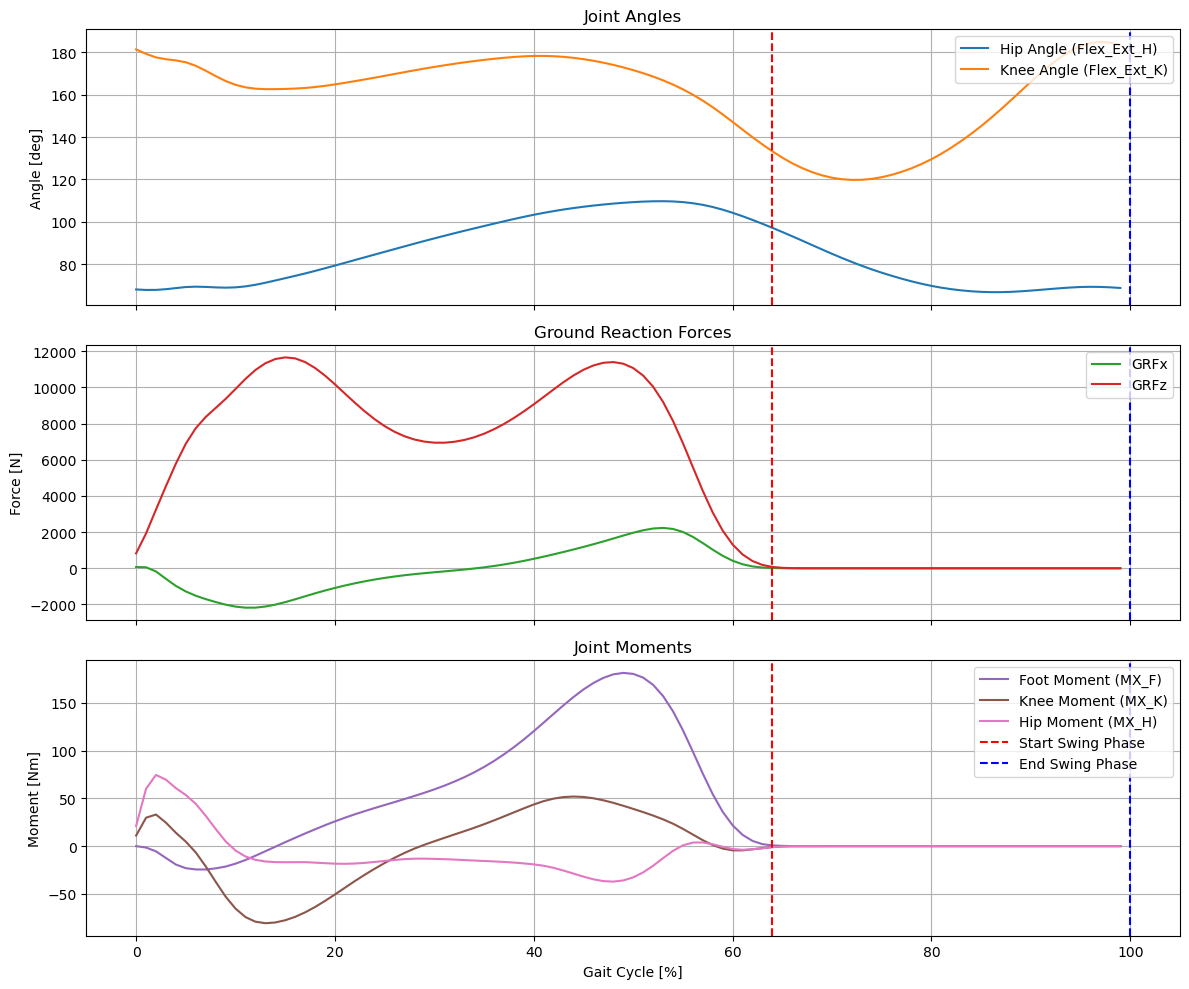

In [189]:
# Plot ground angles, reaction forces, and foot moment
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot angles
axs[0].plot(gait_step, q1_array, label='Hip Angle (Flex_Ext_H)', color='tab:blue')
axs[0].plot(gait_step, q2_array, label='Knee Angle (Flex_Ext_K)', color='tab:orange')
axs[0].set_ylabel('Angle [deg]')
axs[0].legend(loc='upper right')
axs[0].grid(True)
axs[0].axvline(x=start_swing, color='r', linestyle='--', label='Start Swing Phase')
axs[0].axvline(x=100, color='b', linestyle='--', label='End Swing Phase')
axs[0].set_title('Joint Angles')

# Plot ground reaction forces
axs[1].plot(gait_step, GRFx, label='GRFx', color='tab:green')
axs[1].plot(gait_step, GRFz, label='GRFz', color='tab:red')
axs[1].set_ylabel('Force [N]')
axs[1].legend(loc='upper right')
axs[1].grid(True)
axs[1].axvline(x=start_swing, color='r', linestyle='--')
axs[1].axvline(x=100, color='b', linestyle='--')
axs[1].set_title('Ground Reaction Forces')

# Plot foot moments
axs[2].plot(gait_step, MX_F, label='Foot Moment (MX_F)', color='tab:purple')
axs[2].plot(gait_step, MX_K, label='Knee Moment (MX_K)', color='tab:brown')
axs[2].plot(gait_step, MX_H, label='Hip Moment (MX_H)', color='tab:pink')
axs[2].set_ylabel('Moment [Nm]')
axs[2].set_xlabel('Gait Cycle [%]')
axs[2].axvline(x=start_swing, color='r', linestyle='--', label='Start Swing Phase')
axs[2].axvline(x=100, color='b', linestyle='--', label='End Swing Phase')
axs[2].legend(loc='upper right')
axs[2].grid(True)
axs[2].set_title('Joint Moments')

# Adjust layout
plt.tight_layout()
plt.show()

In [184]:
# Leg Model
def leg_model(t, y, M):
    omega1, omega2, q1, q2 = y

    domega1 = dot_omega1_func(q1, q2, omega1, omega2, M)
    domega2 = dot_omega2_func(q1, q2, omega1, omega2, M)

    dq1 = omega1
    dq2 = omega2

    return [domega1, domega2, dq1, dq2]

#### 1.3.2 Hip Drive Model

In [185]:
# Parameters
U_M = 16 # V - motor voltage
U_rated = 48 # V - rated voltage
R = 0.151 # Ohm - resistance
L = 121e-6 # H - inductance
n_0 = 12916 # rpm - no load speed
w_0 = 2 * np.pi * n_0 / 60 # rad/s
k_n = n_0 * 2 * np.pi / (60 * U_rated) # rad/(Vs) - speed constant
k_M = 0.03 # Nm/A - torque constant

J = 5.6e-6 # kgm^2

i_G = 60 # gear ratio
eta_G = 0.85 # gear efficiency

# Dynamic model equations
def motor_model(t, y, u_control, omega_m):
    M = y[0]
    U = U_M * u_control
    n = i_G * omega_m
    I = M / (k_M * i_G * eta_G)
    dI = (U - R * I - n / k_n) / L
    dM = eta_G * i_G * k_M * dI
    return [dM]

In [186]:
# Function of the complete system for the solver
def system_equations(t, y, args):
    dydt_leg = leg_model(t, y[0:2], y[2])
    dydt_motor = motor_model(t, y[2], args, y[0])
    return dydt_leg + dydt_motor

In [187]:
# Class PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, T):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.T = T
        self.e_km1 = 0
        self.e_km2 = 0
        self.u_km1 = 0
        pass

    def compute_control(self, reference, state):
        e_k = reference - state
        a0 = self.Kp + self.Kd / self.T
        a1 = (self.Ki * self.T - 2 * self.Kd / self.T - self.Kp)
        a2 = self.Kd / self.T

        u_k = self.u_km1 + a0 * e_k + a1 * self.e_km1 + a2 * self.e_km2

        self.u_km1 = u_k
        self.e_km2 = self.e_km1
        self.e_km1 = e_k

        return u_k

In [196]:
# Initial value
omega1_0 = ref_dot_q1(0) # Initial angular velocity of the thigh
omega2_0 = ref_dot_q2(0)
q1_0 = ref_q1(0) # Initial angle of the thigh
q2_0 = ref_q2(0) # Initial angle of the shank

initial_state = [omega1_0, omega2_0, q1_0, q2_0]

dt_control = 0.01
dt_sim = 0.001
t_start = 0
t_end = 5
t_control = np.arange(t_start, t_end, dt_control)
num_steps = len(t_control)

In [197]:
# Simulation
def simulation(params):
    Kp, Ki, Kd = params
    controller = PIDController(Kp, Ki, Kd, dt_control)

    # Lists for overall results
    t_total = []
    y_total = []
    torque_array = []
    ref_array = []

    current_state = initial_state

    for i in range(num_steps):
        current_time = t_control[i]

        # Reference
        reference = ref_q1(current_time)

        # Calculate control signal
        torque = controller.compute_control(reference, current_state[1])

        # Define the time span for the current controller interval
        t_span = [current_time, min(current_time + controller.T, t_end)]

        # Calculate the time points for t_eval
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) / dt_sim) + 1)

        # Solve the ODE for the current interval, passing the torque as an argument
        sol = solve_ivp(system_equations, t_span, current_state, args=(torque,), t_eval=t_eval, method='RK45', dense_output=True)

        # Update the current state
        current_state = sol.y[:, -1]

        # Store time and state values
        if len(t_total) == 0:
            t_total.extend(sol.t)
            y_total.extend(sol.y.T)
            # TODO: reference
            torque_array.extend(np.ones(len(sol.t)) * torque)
        else:
            t_total.extend(sol.t[1:])
            y_total.extend(sol.y.T[1:])
            torque_array.extend(np.ones(len(sol.t) - 1) * torque)

    return t_total, y_total, torque_array

In [198]:
t_sol, y_sol, torque_sol = simulation([0.1, 0.1, 0.1])

ValueError: not enough values to unpack (expected 4, got 2)

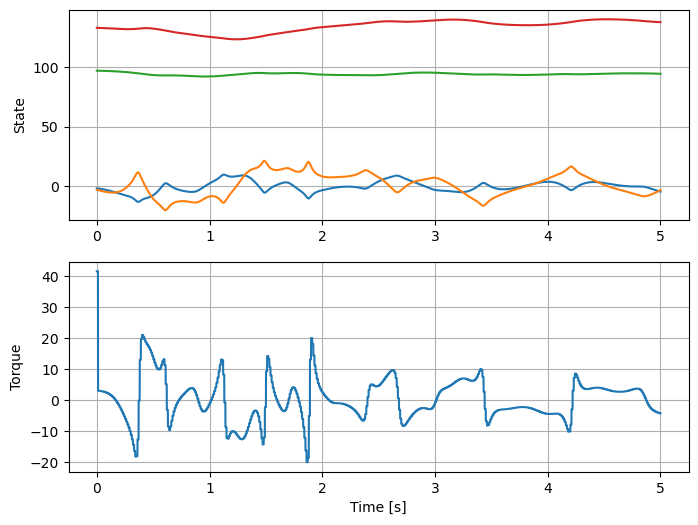

In [144]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(t_sol, y_sol)
plt.ylabel('State')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_sol, torque_sol)
plt.ylabel('Torque')
plt.xlabel('Time [s]')
plt.grid()
plt.show()